# <CENTER> REDES NEURAIS ARTIFICIAIS 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, precision_score, accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
#Função para gerar os pesos das classes

def pesos_classe(contagem_por_classe, contagem_total):
    
    c = 0
    pesos_classes = {}
    
    for classe in contagem_por_classe:
        peso = contagem_total/(len(contagem_por_classe)*classe)
        pesos_classes[c] = peso
        c += 1
    
    return pesos_classes 
        

In [3]:
#Função para plotar a matriz de confusão

def plot_confusion_matrix(y_teste, y_previsão):
    conf_matrix = confusion_matrix(y_teste, y_previsão, labels=[0,1,2,3,4,5])
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt='d')
    ax.xaxis.set_ticklabels(encoder.classes_, rotation = 90)
    ax.yaxis.set_ticklabels(encoder.classes_, rotation = 0)
    plt.show()

In [4]:
#Função para o cálculo de métricas

def metricas_score_ann(modelo, X_teste, y_teste):
    metricas_modelo = {}
    for indice, modelo in enumerate(modelos):
        nome = modelo.__class__.__name__
        previsao = modelo.predict(X_teste)
        f1 = f1_score(y_teste, previsao.round().argmax(axis=1), average='macro')
        precisao = precision_score(y_teste, previsao.round().argmax(axis=1), average='macro')
        acuracia = accuracy_score(y_teste, previsao.round().argmax(axis=1))
        metricas_modelo[indice] = nome, f1, acuracia, precisao
        
    return pd.DataFrame.from_dict(metricas_modelo, orient='index', columns=['Modelo', 'F1', 'Acurácia', 'Precisão'])

In [5]:
#para rodar o tensorflow apenas na CPU (Minha GPU tá com problemas)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [6]:
#Carregando o dataset de Bonin (2020) modificado por mim

df_full = pd.read_csv('dataset/granitos_db_att.csv', sep='\t', index_col=0)

In [7]:
df_temp = df_full.dropna(subset=['MnO', 'TiO2','FeOt', 'MgO', 'Na2O', 'CaO', 'Al2O3'])

In [8]:
#Separando variáveis alvo e variáveis preditoras

preditores = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'K2O', 'Na2O']
alvos = ['Group']

In [9]:
df_preditores = df_temp[preditores]
df_alvo = df_temp[alvos]

In [10]:
#Separando os dados em treino e teste

split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df_preditores, df_alvo):
         X_train, X_test = df_preditores.iloc[train_index], df_preditores.iloc[test_index]
         y_train, y_test = df_alvo.iloc[train_index], df_alvo.iloc[test_index]

In [11]:
#Escalonando as variáveis preditoras e aplicando labelencoder nas variáveis alvo

escaler = StandardScaler()
encoder = LabelEncoder()

X_train = escaler.fit_transform(X_train)
y_train = encoder.fit_transform(np.ravel(y_train))

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)


In [12]:
#para ver ao título das classes
#encoder.classes_

In [13]:
oversample = SMOTE()
X_treino_smote, y_train_smote= oversample.fit_resample(X_train, y_train)

# <CENTER >CRIANDO E IMPLEMENTANDO A REDE NEURAL

In [14]:
rede_neural = keras.models.Sequential()
rede_neural.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural.add(keras.layers.Dense(units=100, activation="relu"))


rede_neural.add(keras.layers.Dense(6, activation="softmax"))

In [15]:
rede_neural2 = keras.models.Sequential()
rede_neural2.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural2.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural2.add(keras.layers.Dense(units=100, activation="relu"))


rede_neural2.add(keras.layers.Dense(6, activation="softmax"))

In [16]:
otimizador = keras.optimizers.SGD(learning_rate = 0.05)

rede_neural.compile(loss="sparse_categorical_crossentropy",
                    optimizer=otimizador,
                    metrics=["accuracy"])

rede_neural2.compile(loss="sparse_categorical_crossentropy",
                    optimizer=otimizador,
                    metrics=["accuracy"])

In [17]:
contagem_por_classe = y_train.value_counts().sort_index().to_list()
contagem_total = y_train.value_counts().sum()
contagem_por_classe, contagem_total

([507, 218, 190, 729, 552, 352], 2548)

In [18]:
pesos = pesos_classe(contagem_por_classe, contagem_total)

In [19]:
modelo_com_pesos = rede_neural.fit(X_train, y_train, epochs=1000, class_weight=pesos, verbose=0, 
                          callbacks=[keras.callbacks.EarlyStopping(patience=10,  monitor="accuracy")] )

In [20]:
modelo_com_oversampling = rede_neural2.fit(X_treino_smote, y_train_smote, epochs=1000, verbose=0, 
                          callbacks=[keras.callbacks.EarlyStopping(patience=10,  monitor="accuracy")] )

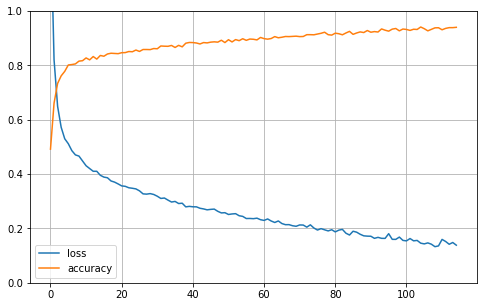

In [21]:
pd.DataFrame(modelo_com_pesos.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

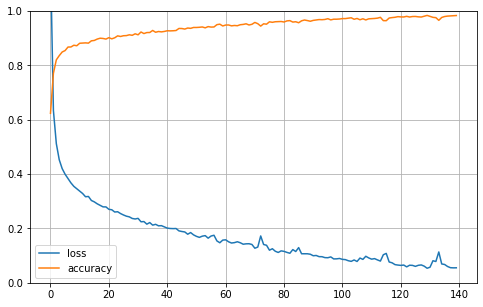

In [22]:
pd.DataFrame(modelo_com_oversampling.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# <CENTER> AVALIANDO O MODELO

In [23]:
#Preparando os dados de teste

X_test = escaler.fit_transform(X_test)
y_teste1 = encoder.fit_transform(np.ravel(y_test))
encoder2 = OneHotEncoder()
y_teste2 = encoder2.fit_transform((y_test))


In [24]:
rede_neural.evaluate(X_test, y_teste1), rede_neural2.evaluate(X_test, y_teste1)

20/20 [==============================] - 0s 1ms/step - loss: 0.8006 - accuracy: 0.8621


([0.5529578328132629, 0.8589341640472412],
 [0.8005822896957397, 0.8620689511299133])

In [25]:
y_pred = rede_neural.predict(X_test)

20/20 [==============================] - 0s 1ms/step


In [26]:
#Classification report do modelo

print(classification_report(y_teste2.toarray().argmax(axis=1), y_pred.round().argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       127
           1       0.96      0.94      0.95        54
           2       0.93      0.85      0.89        48
           3       0.92      0.79      0.85       183
           4       0.77      0.80      0.78       138
           5       0.82      0.92      0.87        88

    accuracy                           0.86       638
   macro avg       0.87      0.87      0.87       638
weighted avg       0.86      0.86      0.86       638



In [30]:
X_test

array([[ 0.33211637, -0.38106862, -0.38806755, ..., -0.57328237,
         1.33155519, -0.34931208],
       [ 0.72185698,  0.64574825, -1.13434087, ..., -0.61160778,
         0.44690752, -0.42755192],
       [ 0.62890629, -0.71544991,  0.16492635, ..., -0.6690959 ,
         0.36265536, -0.16153644],
       ...,
       [-2.34388506,  1.14879975,  1.24943865, ...,  1.30945364,
         0.25433116, -0.75615928],
       [ 1.1360583 , -0.24198968, -1.57458844, ..., -0.40560868,
        -0.21507373, -0.84222312],
       [ 1.06104546, -0.59708486, -2.06852474, ...,  0.8830834 ,
        -1.96631503, -2.40702006]])

In [32]:
y_teste1

array([4, 4, 0, 3, 1, 1, 1, 3, 0, 5, 4, 0, 2, 4, 3, 3, 5, 3, 1, 4, 4, 1,
       5, 4, 4, 3, 3, 1, 3, 0, 0, 3, 5, 3, 4, 5, 3, 1, 5, 0, 0, 3, 3, 3,
       0, 3, 4, 3, 3, 4, 1, 0, 2, 3, 2, 3, 3, 2, 4, 2, 4, 5, 4, 3, 4, 4,
       4, 2, 5, 0, 3, 4, 4, 3, 1, 0, 3, 4, 3, 4, 3, 3, 3, 4, 3, 0, 0, 4,
       0, 3, 5, 3, 3, 4, 0, 0, 1, 4, 0, 3, 0, 3, 4, 5, 0, 0, 5, 1, 0, 4,
       0, 3, 3, 5, 3, 3, 3, 0, 4, 3, 3, 2, 5, 1, 0, 3, 5, 0, 4, 0, 3, 4,
       0, 0, 4, 4, 3, 2, 2, 5, 3, 5, 0, 0, 4, 3, 5, 5, 4, 3, 2, 3, 5, 0,
       3, 3, 3, 4, 2, 0, 5, 2, 4, 4, 4, 2, 0, 3, 1, 3, 1, 5, 5, 2, 0, 5,
       3, 4, 4, 1, 4, 4, 4, 3, 4, 3, 5, 5, 5, 0, 5, 0, 4, 4, 0, 3, 2, 4,
       5, 0, 1, 0, 3, 1, 5, 4, 4, 2, 0, 4, 5, 0, 2, 0, 0, 1, 5, 5, 3, 3,
       4, 0, 4, 0, 3, 3, 0, 0, 4, 3, 0, 1, 3, 5, 3, 3, 3, 2, 3, 5, 5, 1,
       3, 1, 3, 3, 3, 3, 4, 5, 3, 4, 0, 0, 1, 2, 0, 3, 0, 0, 1, 0, 4, 4,
       0, 4, 3, 3, 1, 2, 0, 5, 3, 2, 5, 0, 3, 5, 3, 3, 4, 3, 3, 0, 0, 3,
       4, 4, 1, 4, 5, 5, 0, 3, 3, 4, 4, 3, 5, 5, 3,

In [29]:
modelos = [rede_neural, rede_neural2]
métricas_rnn_scores = metricas_score_ann(modelos, X_test, y_teste1 )
métricas_rnn_scores

20/20 [==============================] - 0s 1ms/step


,Modelo,F1,Acurácia,Precisão
0,Sequential,0.870915,0.855799,0.872956
1,Sequential,0.871305,0.862069,0.868928


In [28]:
pd.DataFrame.to_csv(métricas_rnn_scores, 'métricas_rna_scores.csv', sep='\t')

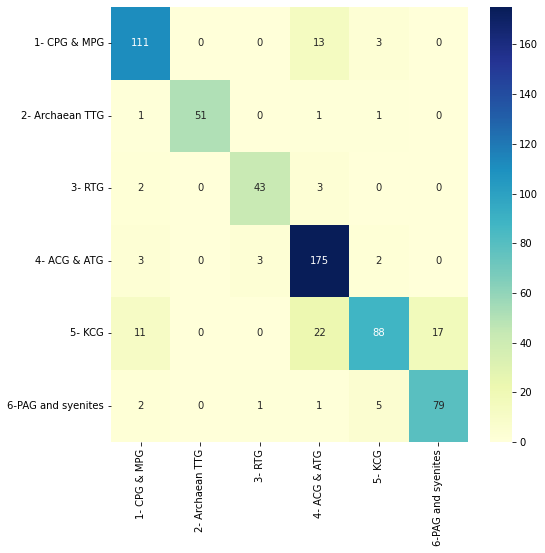

In [29]:
#Plotando a matriz de confusão

plot_confusion_matrix(y_teste2.toarray().argmax(axis=1), y_pred.round().argmax(axis=1))